**Testing Script: Variable hourly input through days**

This version is not working as expected. Ocean Parcels does not allow to have a variable Particle Set for each timestep, keeping always the total amount of particles at every time, even if some of them are not being run within the kernels.

This is not super helpful for later analysis, since we want to know about proportions and processes at every timestep, and with this set up this is not possible and changes in the code to make it happen will INCREASE A LOT the computational cost for each run

In [1]:
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from cartopy import crs, feature
import zarr 
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

NOT WORKING YET...

In [2]:
#from MODEL_OP_V2 import simulation_run
#import useful_params
#import mapitas

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [4]:
clat = [49.195045]
clon = [-123.301956]
dmin = 60

In [5]:
n=100
length = 2

In [6]:
n_hourly = int(n/24) # amount of particles released every hour through the day
#
total_hours = length * 24 # total hours through the simulation
#
release_times = [datetime(2022,1,1) + timedelta(hours=h) for h in range(total_hours)] # set the hourly release times
#

In [7]:
aa = np.arange(0,10)
bb = np.arange(10,20)
cc = np.arange(20,30)
z = 70

In [8]:
np.array([aa,bb,cc]).shape

(3, 10)

In [9]:
lon = np.zeros([len(release_times),n_hourly])
lat = np.zeros([len(release_times),n_hourly])
Z = np.zeros([len(release_times),n_hourly])
for i in range(len(release_times)):
    lon[i,:] = clon[0]
    lat[i,:] = clat[0]
    Z[i,:] = z

In [10]:
lon.shape

(48, 4)

In [11]:
lon = np.repeat(clon[0], total_hours * n_hourly)
lat = np.repeat(clat[0], total_hours * n_hourly)
Z = np.repeat(z, total_hours * n_hourly)
time = np.concatenate([np.repeat(t, n_hourly) for t in release_times])

In [12]:
time

array([datetime.datetime(2022, 1, 1, 0, 0),
       datetime.datetime(2022, 1, 1, 0, 0),
       datetime.datetime(2022, 1, 1, 0, 0),
       datetime.datetime(2022, 1, 1, 0, 0),
       datetime.datetime(2022, 1, 1, 1, 0),
       datetime.datetime(2022, 1, 1, 1, 0),
       datetime.datetime(2022, 1, 1, 1, 0),
       datetime.datetime(2022, 1, 1, 1, 0),
       datetime.datetime(2022, 1, 1, 2, 0),
       datetime.datetime(2022, 1, 1, 2, 0),
       datetime.datetime(2022, 1, 1, 2, 0),
       datetime.datetime(2022, 1, 1, 2, 0),
       datetime.datetime(2022, 1, 1, 3, 0),
       datetime.datetime(2022, 1, 1, 3, 0),
       datetime.datetime(2022, 1, 1, 3, 0),
       datetime.datetime(2022, 1, 1, 3, 0),
       datetime.datetime(2022, 1, 1, 4, 0),
       datetime.datetime(2022, 1, 1, 4, 0),
       datetime.datetime(2022, 1, 1, 4, 0),
       datetime.datetime(2022, 1, 1, 4, 0),
       datetime.datetime(2022, 1, 1, 5, 0),
       datetime.datetime(2022, 1, 1, 5, 0),
       datetime.datetime(2022, 1

NameError: name 'npart' is not defined

In [14]:
def simulation_run(start_time, sim_length, number_particles):
    #
    #
    #### DATA AND OUTPUT PATHS ####
    path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
    'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
    'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
    'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
    'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
    'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly',
    'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
    'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
    #
    coords = xr.open_dataset(path['coords'], decode_times=False)
    mask = xr.open_dataset(path['mask'])
    #### Function for getting dates stamps ####
    def get_timestamps(start_time,sim_length):
        timestamps=[]
        duration = timedelta(days=sim_length)
        for day in range(duration.days):
            timestamps.append([start_time + timedelta(days=day)])
        return np.array(timestamps, dtype='datetime64')
    #
    #### Function to get grid point gridX and gridY ####
    path_NEMO = make_prefix(start_time,path['NEMO'])
    jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
    def finder(lati,loni):
        j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
        i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
        return j,i
    #
    #### Setting deploying cordinates ####
    #
    # IONA OUTFALL COORDINATES
    clat = [49.195045]
    clon = [-123.301956]
    z = 70 # 70 m depth
    #
    n_hourly = int(number_particles/24) # amount of particles released every hour through the day
    #
    #total_hours = sim_length * 24 # total hours through the simulation
    repeatdt = timedelta(hours=1) # release n_hourly amount of particles every hour!!!
    #
    #release_times = [start_time + timedelta(hours=h) for h in range(total_hours)] # set the hourly release times
    #
    lon = clon[0] * np.ones(n_hourly)
    lat = clat[0] * np.ones(n_hourly)
    Z =  z * np.ones(n_hourly)
    #time = np.concatenate([np.repeat(t, n_hourly) for t in release_times])
    #
    a, b = finder(clat[0], clon[0])
    print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
    #
    duration = timedelta(days=sim_length) # RUN DURATION IN DAYS
    #
    #x_offset, y_offset, z = p_deploy(N,n_hourly,dmin,dd,rrr)
    #
    #lon = np.zeros([N,n_hourly])
    #lat = np.zeros([N,n_hourly])
    #for i in range(N):
    #    lon[i,:]=(clon[i] + x_offset[i,:])
    #    lat[i,:]=(clat[i] + y_offset[i,:])
    #
    #
    #### Name of the output file #### 
    name_states = 'PBDEs_run_for_'+str(sim_length)+'_days_'+str(n_hourly)+'_hourly_particles_' 
    daterange = [start_time+timedelta(days=i) for i in range(sim_length)]
    fn =  name_states + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start_time, start_time+duration]) + '.zarr'
    outfile_states = os.path.join(path['out'], fn)
    #
    local = 0
    ####
    ####
    ####
    #### CREATING FIELDSETS ####
    varlist=['U','V','W']
    filenames,variables=filename_set(start_time,sim_length,varlist)
    dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
    field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')
    #
    #Find file names and variable names ###'Diat','Flag'###
    varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol','last_cell_index']
    filenames,variables=filename_set(start_time,sim_length,varlist)
    dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
    density = Field.from_netcdf(filenames['R'], variables['R'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(density)
    #
    #Add Vertical diffusivity coefficient field
    dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
    Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(Kz)
    #
    #Add Bathymetry 2D field
    dimensions = {'lon': 'glamt', 'lat': 'gphit'}
    Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    MBATHY = Field.from_netcdf(filenames['last_cell_index'], variables['last_cell_index'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(MBATHY)
    field_set.add_field(Bth)
    field_set.add_field(TD)
    #
    #Add SSH 
    dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
    SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(SSH)
    #
    # Add e3t
    varlist = ['cell_size']
    filenames,variables=filename_set(start_time,sim_length,varlist)
    dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
    E3T = Field.from_netcdf(filenames['cell_size'], variables['cell_size'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(E3T)
    ####
    ####
    ####
    #### DEFINE A PARTICLE TYPE AND SET ####
    class MPParticle(JITParticle):    
        n = Variable('n', initial = n_hourly)
        vvl_factor = Variable('fact', initial =  1)    
        wa = Variable('wa', initial =  0) 
        wm = Variable('wm', initial =  0)
        initialized = Variable('initialized', initial = 0)
        status = Variable('status') # different status for different processes
    #
    #pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z, time=start_time+timedelta(hours=odt))
    #
    #pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat,
    #depth=Z, time=time)
    pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat,
    depth=Z)#, repeatdt=repeatdt)
    
    ####
    ####
    ####
    ####
    ################ KERNELS ###################
    #
    #### States Kernel for particles release ####
    #### Interaction of 3 different states for PBDEs ####
    # 
    def PBDEs_states(particle, fieldset, time):
        if particle.initialized == 0:#particle.time <= 3600
            n = particle.n 
            # n is the total amount of particles released at the starting location
            data = ParcelsRandom.randint(0, n-1)
            #
            # PBDEs as Sewage Particles
            if data < 3*(n/4):
                particle.status = 1
            #
            # Colloidal/Dissolved PBDEs
            else:
                particle.status = 2
            #
            particle.initialized = 1
            #print('Particle Initialized = 0')    
        else: #particle.time > 3600:
            abso = 0.7/(24)#0.038/(24) #per hour
            deso_s = 3.2/(24) #per hour
            deso_m = 1.8/(24)#1.6/(24) #per hour
            #dt_h = 1 / 3600
            dt_h = math.fabs(particle.dt) / 3600
            value = ParcelsRandom.random()# * dt_h
            #
            #value = ParcelsRandom.random() * dt_h
            if particle.status == 2:
                if value < 1 - math.exp(-abso * dt_h):
                    particle.status = 3
               # From Coloidal/Dissolved form to being attached to a Marine Particle           
            elif particle.status == 1:
                if value < 1 - math.exp(-deso_s * dt_h):
                    particle.status = 2
               # From Sewage Particle to Colloidal/Dissolved PBDE form
            elif particle.status == 3:
                if value < 1 - math.exp(-deso_m * dt_h):
                    particle.status = 2
                # From a Marine Particle to a Colloidal/Dissolved form
            #print('Particle Initialized = 1')
            #if particle.status == 1:  # Sewage Particle
            #    if value < 1 - math.exp(-deso_s * dt_h):
            #        particle.status = 2  # Transition to Colloidal/Dissolved PBDEs
            #elif particle.status == 2:  # Colloidal/Dissolved PBDEs
            #    if value < 1 - math.exp(-abso * dt_h):
            #        particle.status = 3  # Transition to Marine Particle
            #elif particle.status == 3:  # Marine Particle
            #    if value < 1 - math.exp(-deso_m * dt_h):
            #        particle.status = 2  # Transition back to Colloidal/Dissolved PBDEs    
       
    #
    #### PBDEs states sinking velocities features ####
    def PBDEs_forms(particle, fieldset, time):
        #
        #dt_h = 1 / 3600
        dt_h = math.fabs(particle.dt) / 3600
        if particle.status == 1:
            sinkvel = 50*(dt_h) # m/hr * dt --> to seconds
            particle.depth += sinkvel * particle.dt
        #Sewage Particles sink fast        
        elif particle.status == 2:
            sinkvel = 0.0
            particle.depth += sinkvel * particle.dt
        # Colloids just float around and move with advection
        elif particle.status == 3:
            sinkvel = 10*(dt_h) # m/hr * dt --> to seconds
            particle.depth += sinkvel * particle.dt 
        # Marine Particles sink at a slower rate than sewage particles
        #if particle.status == 1:  # Sewage Particles
        #    sinkvel = 3600 / 3600  #to m/s
        #    particle.depth += sinkvel * particle.dt
        #elif particle.status == 2:  # Colloidal/Dissolved PBDEs
        #    sinkvel = 0.0  # No sinking
        #    particle.depth += sinkvel * particle.dt
        #elif particle.status == 3:  # Marine Particles
        #    sinkvel = 1000 / 3600  #to m/s
        #    particle.depth += sinkvel * particle.dt
    #
    #### ADVECTION ####
    def Advection(particle, fieldset, time): 
        # Advection for all PBDEs in status 1, 2 and 3
        if particle.status == 1 or particle.status == 2 or particle.status == 3: 
            ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t) sea surface height
            sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt) sea surface height in the next time step
            td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth 
            particle.fact = (1+ssh/td)
            VVL = (sshn-ssh)*particle.depth/(td)
            #VVL = (sshn-ssh)*particle.depth/(td+ssh)
            (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
            lon1 = particle.lon + u1*.5*particle.dt
            lat1 = particle.lat + v1*.5*particle.dt
            dep1 = particle.depth + w1*.5*particle.dt/particle.fact
            (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
            lon2 = particle.lon + u2*.5*particle.dt
            lat2 = particle.lat + v2*.5*particle.dt
            dep2 = particle.depth + w2*.5*particle.dt/particle.fact
            (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
            lon3 = particle.lon + u3*particle.dt
            lat3 = particle.lat + v3*particle.dt
            dep3 = particle.depth + w3*particle.dt/particle.fact
            (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
            wa = (w1 + 2*w2 + 2*w3 + w4) /6.
            particle.wa = wa* particle.dt
            particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            particle_ddepth = particle.wa/particle.fact + VVL
            if particle_ddepth + particle.depth < 0:
                particle_ddepth = - (2*particle.depth+particle_ddepth)
#        else:
#            particle_dlon = 0
#            particle_dlat = 0
#            particle_ddepth = 0     
    #
    #### TURBULENT MIX ####
    def turb_mix(particle,fieldset,time):
        if particle.status == 1 or particle.status == 2 or particle.status == 3:
            """Vertical mixing"""
            #Vertical mixing
            if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
                Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
            else: 
                Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
            dgrad = Kzdz*particle.dt/particle.fact
            if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
                Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
            else:
                Kz = 0 
            #
            Rr = ParcelsRandom.uniform(-1, 1)
            d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
            dzs = (dgrad + d_random)
            particle.wm = dzs*particle.fact
    #
    #### VERTICAL DISPLACEMENT ####
    def Displacement(particle,fieldset,time):
        if particle.status == 1 or particle.status == 2 or particle.status == 3:
            #Apply turbulent mixing.
            if dzs + particle_ddepth + particle.depth > td:
                particle.depth  = td # Get particles attached to the bottom when they reach it
                particle.status = 4
            #
            elif dzs + particle.depth+ particle_ddepth < 0:
                particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
            #
            else:
                particle_ddepth += dzs #apply mixing
    #
    #### RESUSPENSION ####
    def resuspension(particle, fieldset, time):
        if particle.status == 4:
            threshold = 1 # threshold for particles to know when to resuspend
            # Calculation of U_star, which is proportional to the bottom stress (tau)
            k = 0.42
            z_star = 0.07
            u_horizontal = (1/4) * (fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon -1]) ** 2
            v_horizontal = (1/4) * (fieldset.V[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat - 1, particle.lon]) ** 2
            vel_horizontal = (u_horizontal + v_horizontal) ** (1/2)
            #
            u_star = (vel_horizontal * k) / ((math.log(fieldset.e3t[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] -1, particle.lat, particle.lon] / 2) / z_star))
            # Here tau is the bottom friction parameter estimated from (u_starr)^2 x density
            tau = ((u_star) ** 2) * 1024
            #
            #
            if tau >= threshold: # for colloids and marine particles
                frac_value = ParcelsRandom.randint(0,10)
                if frac_value >= 3:
                    particle.status = 2
                else:
                    particle.status = 3    
            #    
            else:  # for particles staying at the bottom
                particle.status = 4
    #
    #### OTHERS ####
    def export(particle,fieldset,time):
        if particle.lat<48.7 and particle.lon < -124.66:
            particle.status = 7
    #
    def CheckOutOfBounds(particle, fieldset, time):
        if particle.state == StatusCode.ErrorOutOfBounds:    
            particle.delete()
    #        
    def KeepInOcean(particle, fieldset, time):
        if particle.state == StatusCode.ErrorThroughSurface:
            particle.depth = 0.0
            particle.state = StatusCode.Success             
    ##########################################################
    #
    #
    runtime = duration  # Total simulation runtime
    dt = 1     # Simulation timestep in seconds
    output_interval = timedelta(hours=1)
    output_file = pset_states.ParticleFile(name=outfile_states, outputdt=output_interval)
    kernels = [PBDEs_states, PBDEs_forms, Advection, turb_mix, Displacement, resuspension, CheckOutOfBounds, export, KeepInOcean]
    #
    #
    time = 0  # Start time of the simulation in seconds
    while time < runtime.total_seconds():
        pset_states.execute(
            kernels,
            runtime=output_interval,
            dt=dt,
            output_file=output_file, verbose_progress=False
        )
        # Add new particles
        time += output_interval.total_seconds()
        new_particles = ParticleSet.from_list(field_set,
        MPParticle, lon=lon, lat=lat, depth=Z)
        pset_states.add(new_particles)
    #
    return outfile_states

In [ ]:
# add particles just for the first day but start analysis from the second day :D
# release hourly for the first day
#
# then 1 week with hourly release and start analysis from second week
#
# same monthly and compare between months

In [18]:
# do 2 days run to test if its working :D
#file_name = simulation_run(datetime(2022,1,1), 1, 200)

The total depth at this location is 85.375 m


/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(lonlat_filename, dimensions, indices, netcdf_engine) as filebuffer:
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(lonlat_filename, dimensions, indices, netcdf_engine) as filebuffer:
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded prope

INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly/PBDEs_run_for_1_days_8_hourly_particles_20220101_1n_20220102_1n.zarr.


/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/ast.py:418: KernelWarning: Don't change the location of a particle directly in a Kernel. Use particle_dlon, particle_dlat, etc.
  return visitor(node)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/kernel.py:251: KernelWarning: dt_h declared in multiple Kernels
  kernel_ccode = kernelgen.generate(deepcopy(self.py_ast), self.funcvars)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly/PBDEs_run_for_1_days_8_hourly_particles_20220101_1n_20220102_1n.zarr.
INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly/PBDEs_run_for_1_days_8_hourly_particles_20220101_1n_20220102_1n.zarr.
INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly/PBDEs_run_for_1_days_8_hourly_particles_20220101_1n_20220102_1n.zarr.
INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly/PBDEs_run_for_1_days_8_hourly_particles_20220101_1n_20220102_1n.zarr.
INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly/PBDEs_run_for_1_days_8_hourly_particles_20220101_1n_20220102_1n.zarr.
INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly/PBDEs_run_for_1_days_8_hourly_particles_2022

In [15]:
file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Tests_hourly/PBDEs_run_for_1_days_8_hourly_particles_20220101_1n_20220102_1n.zarr'

In [16]:
data = xr.open_zarr(file_name)
depth = data.z/data.fact

In [17]:
data.lon[:8,0].values

array([-123.301956, -123.301956, -123.301956, -123.301956, -123.301956,
       -123.301956, -123.301956, -123.301956])

In [20]:
data.time[:8,0].values

array(['2022-01-01T00:30:00.000000000', '2022-01-01T00:30:00.000000000',
       '2022-01-01T00:30:00.000000000', '2022-01-01T00:30:00.000000000',
       '2022-01-01T00:30:00.000000000', '2022-01-01T00:30:00.000000000',
       '2022-01-01T00:30:00.000000000', '2022-01-01T00:30:00.000000000'],
      dtype='datetime64[ns]')

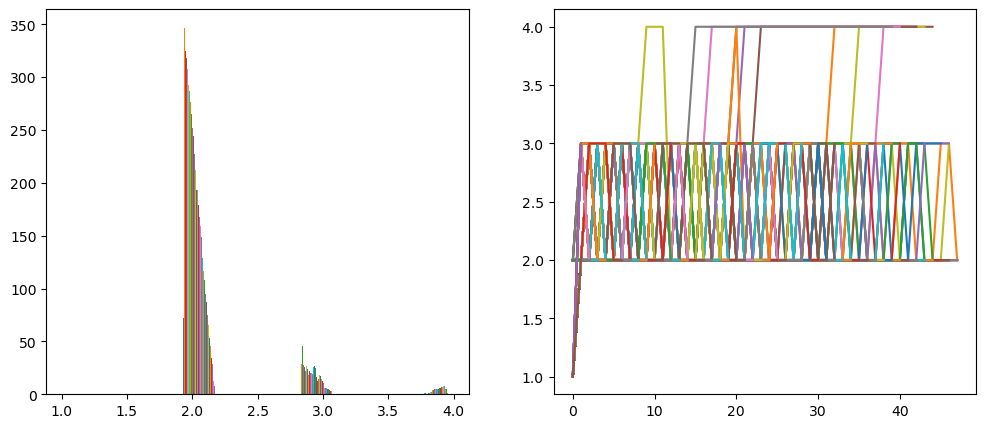

In [37]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].hist(data.status)
ax[1].plot(data.status.T)

In [67]:
np.arange(0,48,7) 

array([ 0,  7, 14, 21, 28, 35, 42])

IndexError: Index 2 is out of bounds for axis 1 with size 1

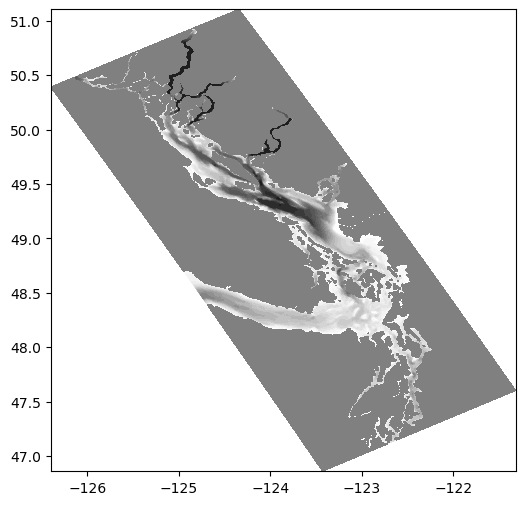

In [21]:
fig,axs=plt.subplots(figsize=(6,6))
tt = 2
#dt=10
#tt = 30
blevels = list(np.arange(0,500,20))
im=axs.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap = 'Greys',levels=blevels)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
#axs.scatter(data.lon[:,tt+dt], data.lat[:,tt+dt], c = 'r', s = 5)
axs.scatter(data.lon[:,tt], data.lat[:,tt], c = 'k', s = 5)
axs.set_ylim([clat[0]-0.1,clat[0]+0.1])
axs.set_xlim([clon[0]-0.1,clon[0]+0.1])
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')

Text(0, 0.5, 'Latitude')

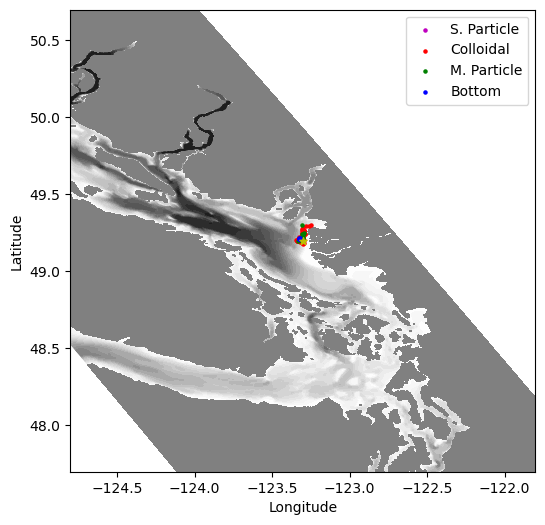

In [50]:
fig,axs=plt.subplots(figsize=(6,6))
#
tt = 30
#
# Make map
blevels = list(np.arange(0,500,20))
im=axs.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap = 'Greys',levels=blevels)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 1),data.lat[:,tt].where(data.status[:,tt] == 1),zorder=3,c='m',s=5, label = 'S. Particle')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 2),data.lat[:,tt].where(data.status[:,tt] == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 3),data.lat[:,tt].where(data.status[:,tt] == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 4),data.lat[:,tt].where(data.status[:,tt] == 4),zorder=3,c='b',s=5, label = 'Bottom')
#
axs.legend()
axs.scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs.set_ylim([clat[0]-1.5,clat[0]+1.5])
axs.set_xlim([clon[0]-1.5,clon[0]+1.5])
#axs[0].set_title(f'Final Particles position during '+ str(date_jan_end))
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')

In [40]:
import useful_params
import mapitas

In [41]:
cat = ['S.Particles', 'Colloidal', 'M. Particles', 'Bottom']
aa_in, aa_fin, aa = useful_params.percentages(file_name)
propor = useful_params.proportions(file_name)*100

(0.0, 100.0)

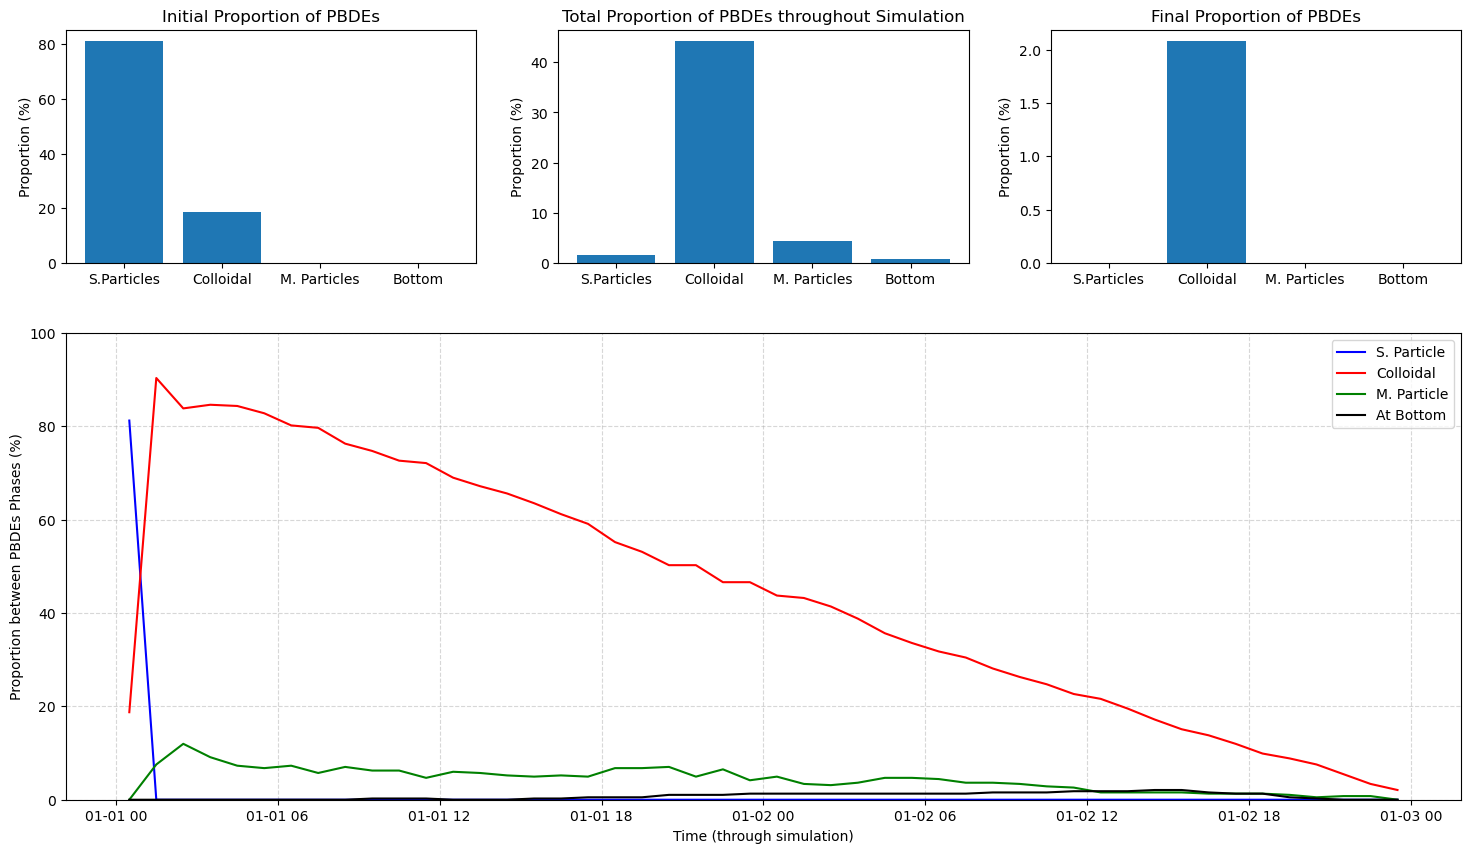

In [42]:
fig = plt.figure(figsize = (18,10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.bar(cat, aa_in)
ax1.set_title('Initial Proportion of PBDEs')
ax1.set_ylabel('Proportion (%)')
ax2.bar(cat, aa)
ax2.set_title('Total Proportion of PBDEs throughout Simulation')
ax2.set_ylabel('Proportion (%)')
ax3.bar(cat, aa_fin)
ax3.set_title('Final Proportion of PBDEs')
ax3.set_ylabel('Proportion (%)')
#
ax4 = fig.add_subplot(gs[1, :])

ax4.plot(propor['Sewage'], 'b', label = 'S. Particle')
ax4.plot(propor['Colloidal'], 'r', label = 'Colloidal')
ax4.plot(propor['Marine'], 'g', label = 'M. Particle')
ax4.plot(propor['Bottom'], 'k', label = 'At Bottom')
ax4.set_ylabel('Proportion between PBDEs Phases (%)')
ax4.set_xlabel('Time (through simulation)')
ax4.legend()
ax4.grid(linestyle = '--', alpha = 0.5)
#ax.set_title('Particle status proportion between ' + str(date_jan_start) + ' and ' + str(date_jan_end))
ax4.set_ylim(0,100)